In [1]:
import numpy as np 
import pandas as pd
# for local
TRAIN_DIR = "../data/input/train.csv"
TEST_DIR = "../data/input/test.csv"
SUBMIT_DIR = "../data/output/sample_submission.csv"

# for kaggle notebook
# TRAIN_DIR = "/kaggle/input/icr-identify-age-related-conditions/train.csv"
# TEST_DIR = "/kaggle/input/icr-identify-age-related-conditions/test.csv"
# SUBMIT_DIR = "/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv"

In [2]:
train = pd.read_csv(TRAIN_DIR)
test = pd.read_csv(TEST_DIR)

train["EJ"] = train["EJ"].map({"A":0,"B":1})
test["EJ"] = test["EJ"].map({"A":0,"B":1})

In [3]:
from sklearn.impute import SimpleImputer,KNNImputer
imputer = KNNImputer(n_neighbors=50)

X = train.drop(["Id","Class"],axis=1)
X = imputer.fit_transform(X)
y = train[["Class"]].to_numpy()

X_test = test.drop("Id",axis=1)
X_test = imputer.fit_transform(X_test)

In [4]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import log_loss
import optuna
optuna.logging.disable_default_handler()
# optuna.logging.enable_default_handler()
from mylib.log import optuna_log_write
from mylib.score import *

scorer = make_scorer(competition_log_loss,needs_proba=True)

# Lightgbm tuning

In [16]:
def objective(trial):
    
    params_lgb = {"n_estimators":trial.suggest_int("n_estimators",50,400),
                  "num_leaves":trial.suggest_int("num_leaves",8,32),
                  "max_depth":trial.suggest_int("max_depth",3,15),
                  "learning_rate":trial.suggest_float("learning_rate",0.001,0.3,log=True),
                  "subsample":trial.suggest_float("subsample",0.1,1),
                  "colsample_bytree":trial.suggest_float("colsample/bytree",0.1,1),
                  "reg_lambda":trial.suggest_float("reg_lambda",1e-9,10,log=True),
                  "boosting_type":"gbdt",
                  "device":"cpu",
                  "random_state":10,
                  "objective":"binary",
                 }
    
    
    model = LGBMClassifier(**params_lgb)
    kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
    logloss_list = []
    
    for train_index,val_index in kf.split(X,y):
        train_X,val_X = X[train_index,:],X[val_index,:]
        train_y,val_y = y[train_index],y[val_index]
        
        model.fit(train_X,train_y.reshape(-1))
        pred_proba = model.predict_proba(val_X)
        
        logloss = log_loss(val_y,pred_proba)
        logloss_list.append(logloss)
        
    return np.mean(logloss_list)
    
trial_num =1000
study = optuna.create_study(direction="minimize")
study.optimize(objective,n_trials=trial_num)
optuna_log_write(study,trial_num,file_name="lgb_tuning")


# Xgboost tuning

In [17]:
def objective(trial):
    
    params_xgb = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'max_depth': int(trial.suggest_int('max_depth', 3, 15)),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'eta': trial.suggest_float('eta', 0.01, 0.8),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    
    model = XGBClassifier(**params_xgb)
    kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
    logloss_list = []
    
    for train_index,val_index in kf.split(X,y):
        train_X,val_X = X[train_index,:],X[val_index,:]
        train_y,val_y = y[train_index],y[val_index]
        
        model.fit(train_X,train_y.reshape(-1))
        pred_proba = model.predict_proba(val_X)
        
        logloss = log_loss(val_y,pred_proba)
        logloss_list.append(logloss)
        
    return np.mean(logloss_list)
    
trial_num =1000
study = optuna.create_study(direction="minimize")
study.optimize(objective,n_trials=trial_num)
optuna_log_write(study,trial_num,file_name="xgb_tuning")


# Catboost tuning

In [6]:
# def objective(trial):
    
#     params_cat = {
#         "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.5, log=True),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#         ),
#         "used_ram_limit": "3gb",
#         "eval_metric": "Accuracy",
#     }

    
#     model = CatBoostClassifier(**params_cat)
#     kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
#     logloss_list = []
    
#     for train_index,val_index in kf.split(X,y):
#         train_X,val_X = X[train_index,:],X[val_index,:]
#         train_y,val_y = y[train_index],y[val_index]
        
#         model.fit(train_X,train_y.reshape(-1))
#         pred_proba = model.predict_proba(val_X)
        
#         logloss = log_loss(val_y,pred_proba)
#         logloss_list.append(logloss)
        
#     return np.mean(logloss_list)
    
# trial_num =100
# study = optuna.create_study(direction="minimize")
# study.optimize(objective,n_trials=trial_num)
# optuna_log_write(study,trial_num,file_name="cat_tuning")


In [9]:
params = {'n_estimators': 400, 
          'num_leaves': 16,
          'max_depth': 3,
          'learning_rate': 0.08405720120473595,
          'subsample': 0.3064498908317925,
          'colsample/bytree': 0.6588735233587487,
          'reg_lambda': 8.455357407692809}

model = LGBMClassifier(**params)
model.fit(X,y.reshape(-1))
model.feature_importances_


array([162,  48,   9,  67,   2,  76,   9,   3,  48,  25,  37,  33,  93,
         7,   0,  25,  63,  37,   8,  32,  22,  88,  35,  12,  30, 106,
        67,   9,  10,  51, 115,  82, 158,   5,  88,  68,  88,  64,   6,
         0,  48,  62,  44,   2,  27,  72,  77,  87,  45,  39,   1,  27,
         3,  38,  10,  74], dtype=int32)

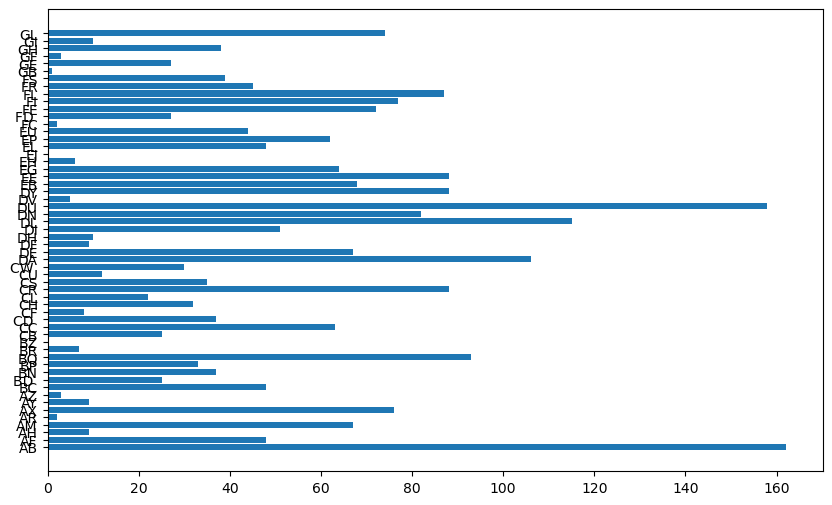

In [11]:
import matplotlib.pyplot as plt

labels = train.drop(["Id","Class"],axis=1).columns
importances = model.feature_importances_

plt.figure(figsize = (10,6))
plt.barh(y = range(len(importances)), width = importances)
plt.yticks(ticks = range(len(labels)), labels = labels)
plt.show()

In [10]:
train.drop(["Id","Class"],axis=1).columns

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0
